In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [2]:
import zipfile,os

base_dir='/content/drive/MyDrive/Colab Notebooks/datasets/gendermelanes'
os.listdir(base_dir)

['female', 'male']

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   shear_range = 0.2, 
                                   horizontal_flip=True, 
                                   fill_mode ='nearest',
                                   validation_split = 0.2
                                   )
test_datagen = ImageDataGenerator(rescale=1./255, 
                                  zoom_range = 0.2, 
                                  shear_range = 0.2, 
                                  horizontal_flip=True,
                                  fill_mode = 'nearest', 
                                  validation_split = 0.2
                                 )

In [4]:
train_generator = train_datagen.flow_from_directory(
        base_dir,  
        target_size=(150, 150),  
        shuffle = True,
        subset='training')
     
validation_generator = test_datagen.flow_from_directory(
        base_dir, 
        target_size=(150, 150),  
        subset='validation')

Found 328 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16 = VGG16(input_shape = (150, 150, 3), weights = "imagenet", include_top = False)

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
for layer in vgg16.layers:
  layer.trainable = False

In [7]:
from tensorflow.keras import layers
x = layers.Flatten()(vgg16.output)
prediction = layers.Dense(2, activation="softmax")(x)
model = tf.keras.models.Model(inputs = vgg16.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

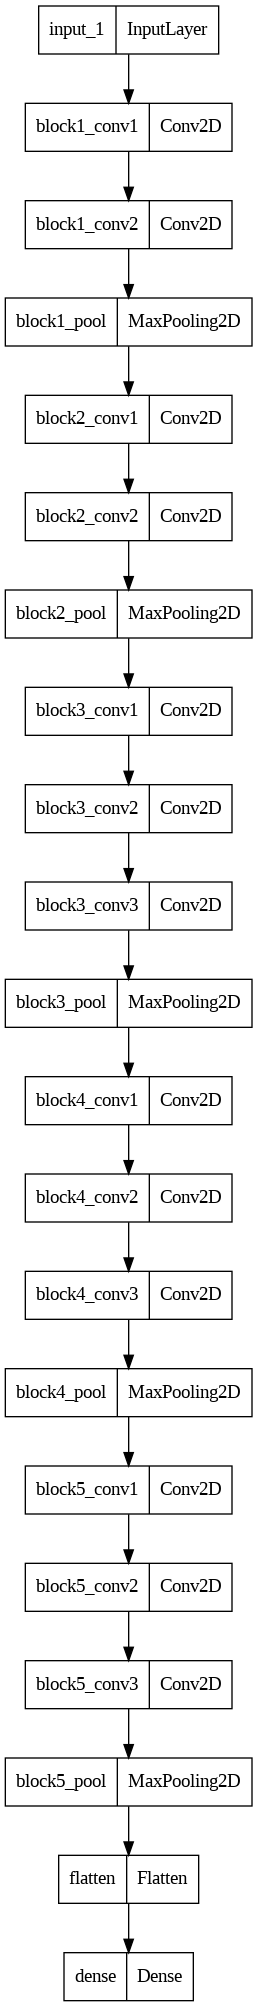

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)
plot_model(model)

In [9]:
#opt=tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [10]:
class Reminder(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        ACCURACY_THRESHOLD = 0.95
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nTarget reached %2.2f%%. Stop Training" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

reminderCB = Reminder()

In [11]:
fitting_history = model.fit(
                      train_generator,
                      epochs=20,
                      validation_data=validation_generator, 
                      verbose=1,
                      callbacks = [reminderCB]
                    )

Epoch 1/20
11/11 [==============================] - 148s 13s/step - loss: 0.7372 - accuracy: 0.5427 - val_loss: 0.6238 - val_accuracy: 0.6420
Epoch 2/20
11/11 [==============================] - 132s 12s/step - loss: 0.5848 - accuracy: 0.7378 - val_loss: 0.5852 - val_accuracy: 0.7284
Epoch 3/20
11/11 [==============================] - 132s 12s/step - loss: 0.5252 - accuracy: 0.7409 - val_loss: 0.5285 - val_accuracy: 0.7407
Epoch 4/20
11/11 [==============================] - 132s 12s/step - loss: 0.5177 - accuracy: 0.7470 - val_loss: 0.6616 - val_accuracy: 0.5926
Epoch 5/20
11/11 [==============================] - 136s 13s/step - loss: 0.4720 - accuracy: 0.7805 - val_loss: 0.4888 - val_accuracy: 0.7654
Epoch 6/20
11/11 [==============================] - 132s 12s/step - loss: 0.4225 - accuracy: 0.8293 - val_loss: 0.4476 - val_accuracy: 0.8395
Epoch 7/20
11/11 [==============================] - 133s 13s/step - loss: 0.4289 - accuracy: 0.8140 - val_loss: 0.4145 - val_accuracy: 0.8148
Epoch 

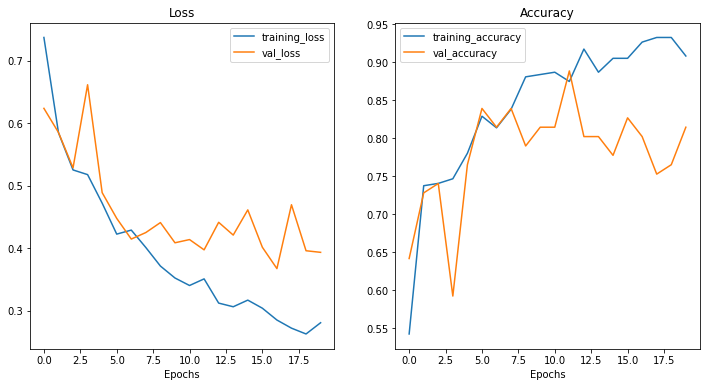

In [12]:
import matplotlib.pyplot as plt

def plot_loss_curves(fitting_history):
  loss = fitting_history.history['loss']
  val_loss = fitting_history.history['val_loss']

  accuracy = fitting_history.history['accuracy']
  val_accuracy = fitting_history.history['val_accuracy']

  epochs = range(len(fitting_history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss_curves(fitting_history)

In [13]:
model.evaluate(train_generator), model.evaluate(validation_generator)

3/3 [==============================] - 22s 6s/step - loss: 0.3908 - accuracy: 0.7901


([0.2644865810871124, 0.917682945728302],
 [0.3907894194126129, 0.790123462677002])

<ipython-input-26-dc1031a5ccb3>:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(train_generator)


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

      female       0.52      0.57      0.54       167
        male       0.50      0.45      0.48       161

    accuracy                           0.51       328
   macro avg       0.51      0.51      0.51       328
weighted avg       0.51      0.51      0.51       328



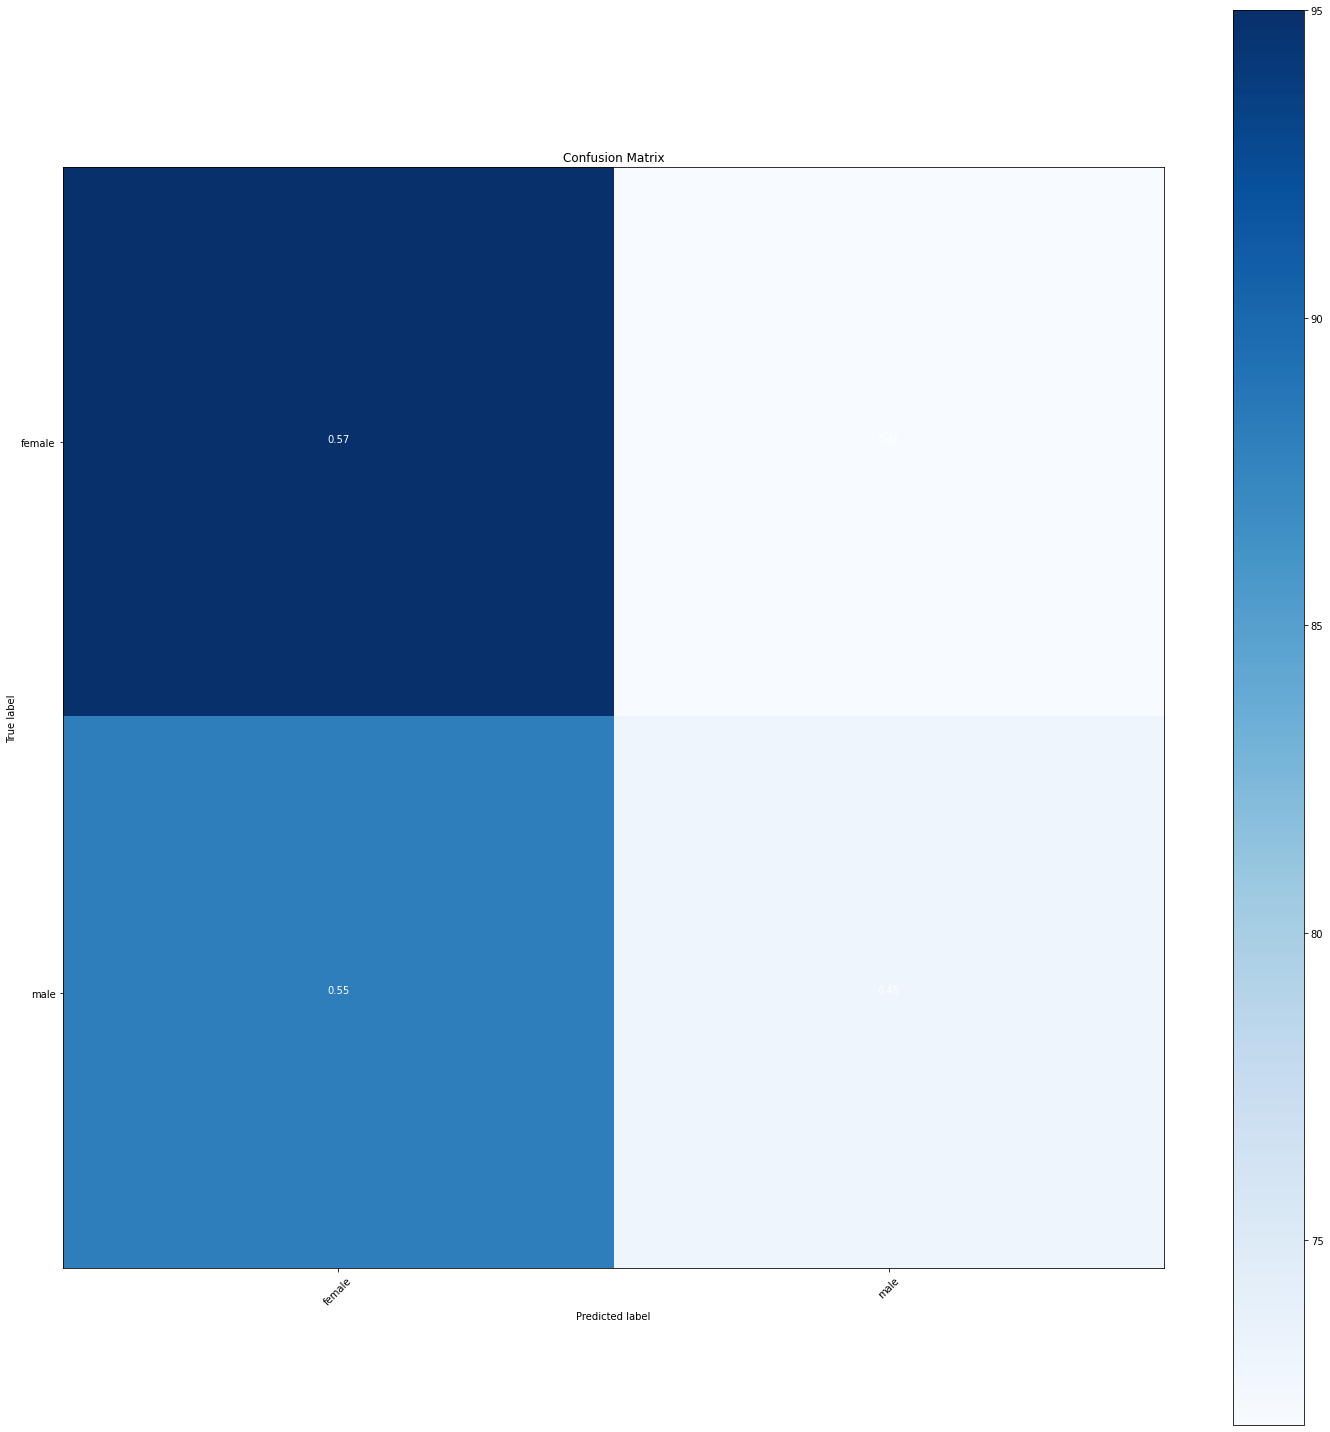

In [26]:
#Plot the confusion matrix. Set Normalize = True/False
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(train_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(train_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

In [15]:
train_generator.class_indices

{'female': 0, 'male': 1}

Saving FB_IMG_1674738285332.jpg to FB_IMG_1674738285332.jpg
1/1 [==============================] - 1s 583ms/step
0
female


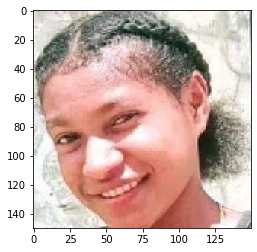

In [22]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()
 
for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  output_class = np.argmax(classes)
  print(output_class)
  if output_class==0:
    print('female')
  elif output_class==1:
    print('male')

In [17]:
model.save("gendervgg16.h5")

In [24]:
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)

Classes:['female', 'male']


11/11 [==============================] - 99s 9s/step


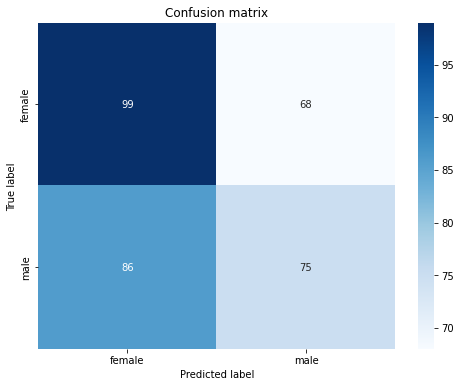

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(train_generator), axis=1)
cm = confusion_matrix(train_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()